In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Create the complicated function as mentioned:

In [2]:
def sigmoid(x, a, b, c, d):
    """
    Returns the sigmoid function f(x) = a/(1 + e^(-(bx - c))) + d 
    
    Parameters are:
    
    a adjusts the minimum and maximum asymptotes of the sigmoidal curve
    b adjusts the steepness of the sigmoidal curve
    c shifts the curve left and right
    d shifts the curve up and down
    
    """
    return a/(1 + np.exp(-(b * x - c))) + d

def neg_exponential(x, a, b, c, d):
    """
    Returns the negative exponential function f(x) = a * e^-bx + c
    
    Parameters are:
    
    a shifts the curve left and right
    b adjusts the steepness of the curve
    c is the horizontal asymptote
    d shifts the curve left and right
    
    """
    return a * np.exp(-b * (x + d)) + c
    

def log_likelihood(params, a_a=0., b_a=1.5, c_a=6., d_a=0., 
                           a_dm=0., b_dm=1.5, c_dm=6., d_dm=9., 
                           a_sa=10000., b_sa=-2, c_sa=1.5, d_sa=-10, 
                           a_sdm=0., b_sdm=0., c_sdm=0.2, d_sdm=0, 
                           a_g=1., b_g=1.5, c_g=9., d_g=0.):
    """
    Negative Log-likelihood function defined below, with the dark matter parameters
    
    param params: tuple of 3 numbers x, y, z
    """
    omega_a, omega_dm, m_a = params  # x is omega_a, y is omega_dm, z is m_a
    
    # x vector
    x = np.array([omega_a, omega_dm])  # x = [omega_a, omega_dm] vector
    
    # means in the mu_a and mu_de direction
    # sigmoid curves mu_a(m_a) and mu_de(m_a)
    mu_a = sigmoid(m_a, a_a, b_a, c_a, d_a)  # mu_a = mu_a(m_a)
    mu_dm = sigmoid(m_a, a_dm, b_dm, c_dm, d_dm)  # mu_dm = mu_dm(m_a) but the sigmoidal curve has different parameters
    # mu is a vector of the two
    mu = np.array([mu_a, mu_dm])  # mu = [mu_a, mu_dm] vector
    
    # covariance matrix C
    sigma_a = neg_exponential(m_a, a_sa, b_sa, c_sa, d_sa)  # variance in a direction: negative exponential curve, sigma_a = sigma_a(m_a)
    sigma_dm = neg_exponential(m_a, a_sdm, b_sdm, c_sdm, d_sdm)  # variance in de direction: sigmoid curve, sigma_de = sigma_de(m_a)
#     sigma_a = sigmoid(m_a, a_sa, b_sa, c_sa, d_sa)  # variance in a direction: sigmoid curve, sigma_a = sigma_a(m_a)
#     sigma_de = sigmoid(m_a, a_sde, b_sde, c_sde, d_sde)  # variance in de direction: sigmoid curve, sigma_de = sigma_de(m_a)
    
    # multiply a and d to scale this to go from pi/2 -> 0, since we want to rotate from 0 degrees to 45 
    theta = sigmoid(m_a, a_g * -np.pi/4, b_g, c_g, d_g * -np.pi/4)  # covariance: sigmoid curve, g = g(m_a)
    # covariance matrix
    C = np.array(([sigma_a, 0],   # C = [[sigma_a, g], [g, sigma_de]]
                  [0, sigma_dm]))
    # rotation matrix
    rot = np.array(([np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]))
    
    # return 2d gaussian, applying the appropriate rotation
    f = np.exp(-((x - mu).T @ np.linalg.inv(rot @ C @ rot.T) @ (x - mu)))  # general expression for a 2D Gaussian
    
    return f
    

Plot all the curves to make sure the function behaviour is working as intended:

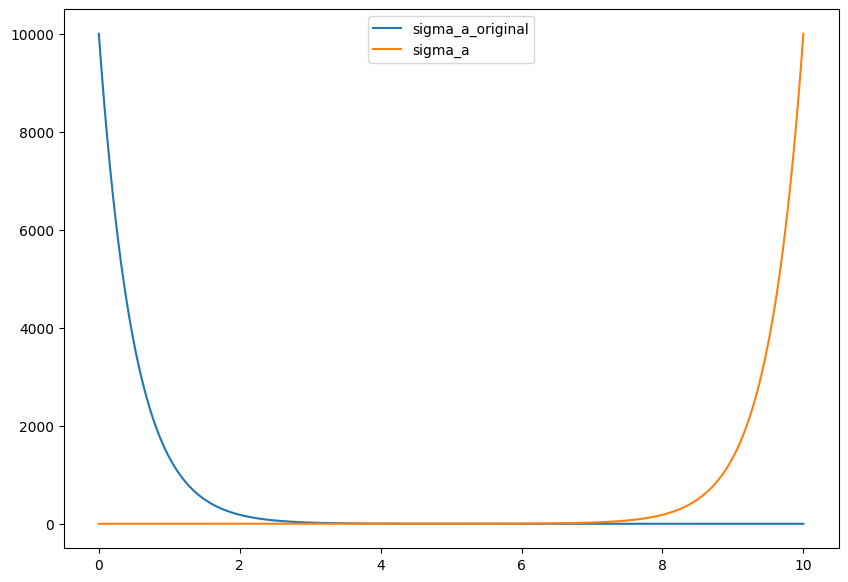

In [3]:
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(0, 10, int(1e4)), neg_exponential(np.linspace(0, 10, int(1e4)), 10000., 2, 1.5, 0), label = 'sigma_a_original')
plt.plot(np.linspace(0, 10, int(1e4)), neg_exponential(np.linspace(0, 10, int(1e4)), 10000., -2, 1.5, -10), label = 'sigma_a')  # sigma_a
plt.legend()
plt.show()

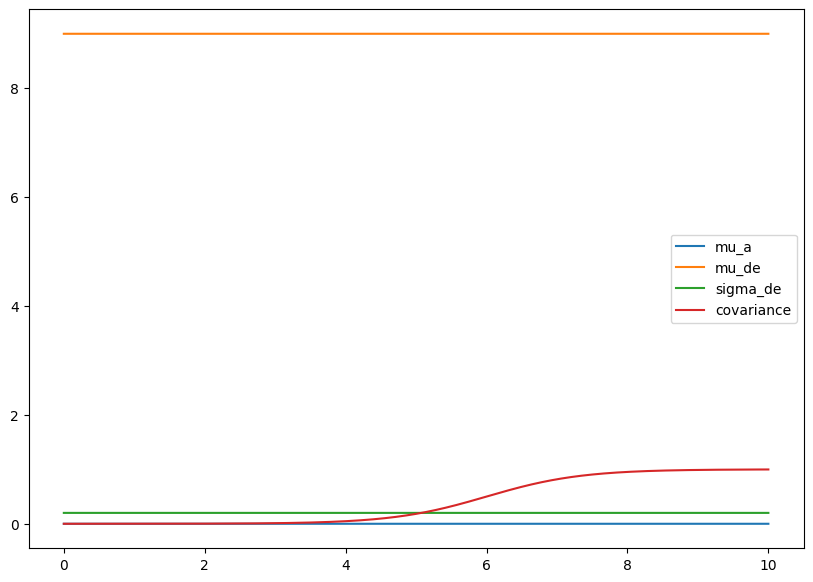

In [4]:
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(0, 10, int(1e4)), sigmoid(np.linspace(0, 10, int(1e4)), a=0, b=1.5, c=6, d=0), label = 'mu_a')  # mu_a
plt.plot(np.linspace(0, 10, int(1e4)), sigmoid(np.linspace(0, 10, int(1e4)), a=0, b=1.5, c=6, d=9), label = 'mu_de')  # mu_de
plt.plot(np.linspace(0, 10, int(1e4)), sigmoid(np.linspace(0, 10, int(1e4)), a=0., b=1.5, c=6, d=0.2), label = 'sigma_de')  # sigma_de
plt.plot(np.linspace(0, 10, int(1e4)), sigmoid(np.linspace(0, 10, int(1e4)), a=1, b=1.5, c=9, d=0), label = 'covariance')  # covariance
plt.legend()
plt.show()

Compute the function over some cube:

In [5]:
npoints = 100

# bounds of our sampling
x_lower, x_upper = 0, 10
y_lower, y_upper = 0, 10
z_lower, z_upper = 0, 10
# w_lower, w_upper = -5, 5

testarr = np.zeros((npoints, npoints, npoints))
# testarr = np.zeros((npoints, npoints, npoints, npoints))
X, Y, Z = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints))
# X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
#                          np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))

for i in tqdm(range(0, len(X))):
    for j in range(0, len(Y)):
         for k in range(0, len(Z)):
                testarr[i, j, k] = log_likelihood((X[i, j, k], Y[i, j, k], Z[i, j, k]))

# for i in range(0, len(X)):
#     for j in range(0, len(Y)):
#         for k in range(0, len(Z)):
#             for w in range (0, len(W)):
#                 testarr[i, j, k, w] = log_likelihood((X[i, j, k, w], Y[i, j, k, w], Z[i, j, k, w], W[i, j, k, w]))

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Plotting:

In [6]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
zs = np.linspace(z_lower, z_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(z_ind):
    ax.clear()
    arr = testarr[:, :, z_ind]
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    
    ax.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    # cb = plt.colorbar()
    # cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)
    
    # ax.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax2 = ax.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    # fig2 = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    # plt.clabel(fig2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_dm, z is m_a
    #    plt.tight_layout()
    ax.set_title(fr'$m_a = ${np.round(zs[z_ind], 2)}') # x is omega_a, y is omega_de, z is m_a
    
# plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
# cb = plt.colorbar()
# cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

# fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(fig, inline=True, fontsize=10)
# plt.xlabel('X'), plt.ylabel('Y')
# plt.tight_layout()
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("3d_u_function_dm.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

10.0


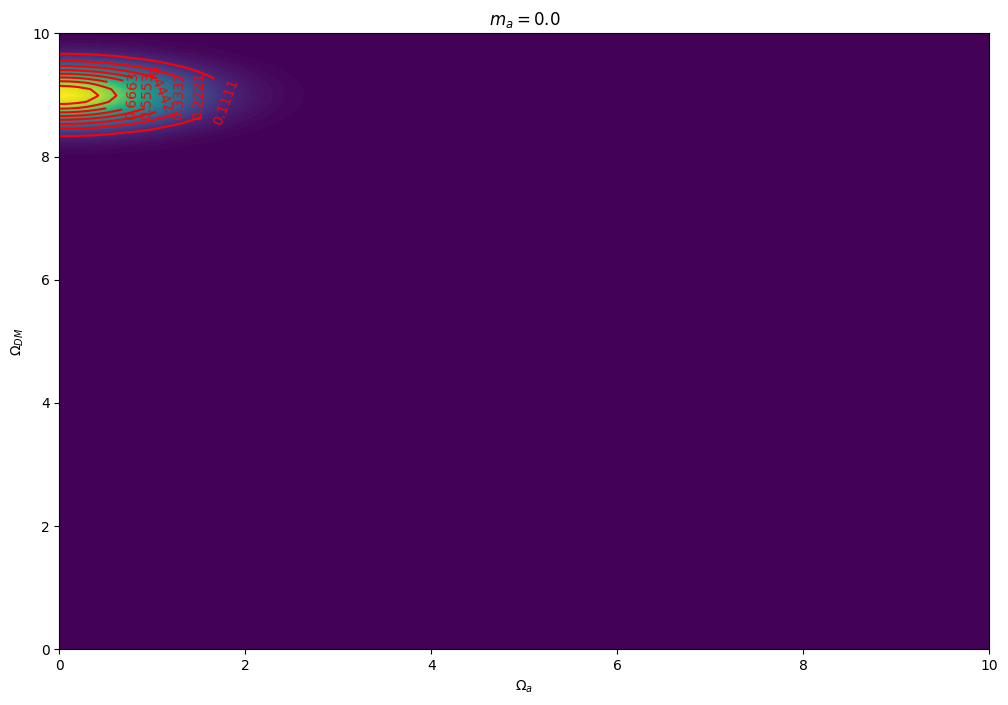

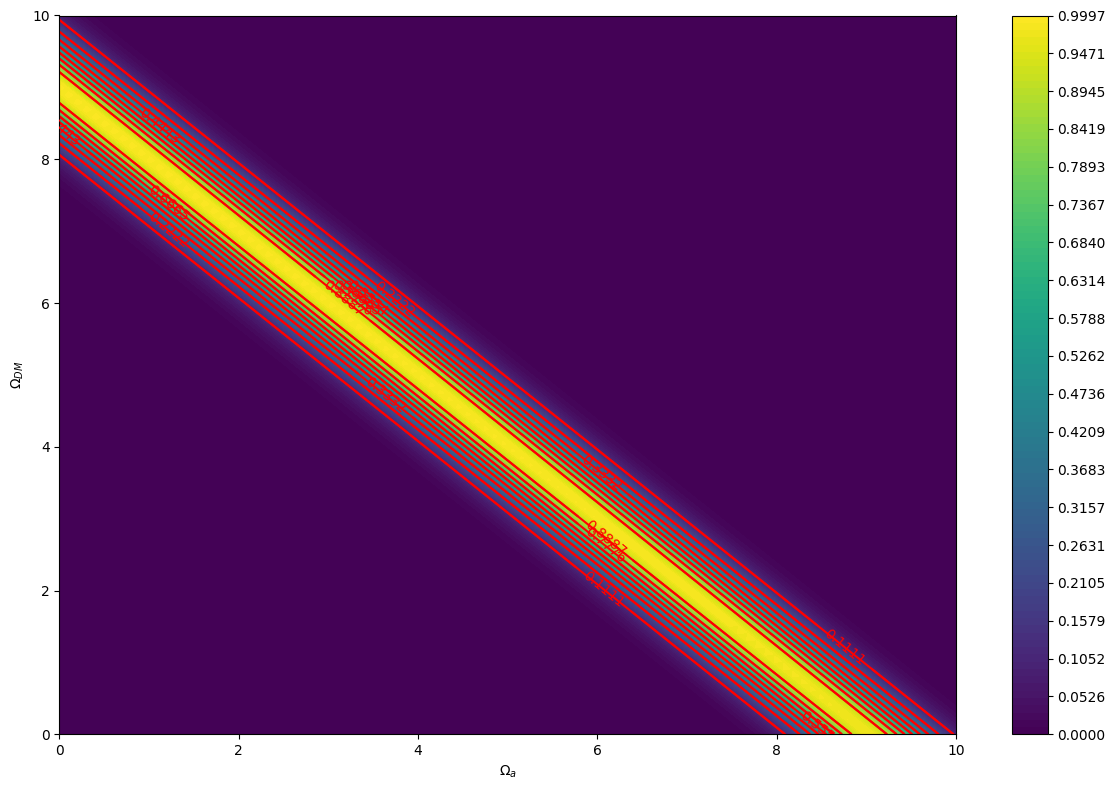

In [7]:
z_ind = 99

print(np.linspace(z_lower, z_upper, npoints)[z_ind])
arr = testarr[:, :, z_ind]  # array of X, Y points to plot

# min and max for the contours
contour_min = np.min(arr)
contour_max = np.max(arr)

# plot

plt.figure(figsize = (12, 8))
plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
cb.set_ticks(np.linspace(contour_min, contour_max, 20))#, update_ticks=True)

plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.xlabel(r'$\Omega_{a}$'), plt.ylabel(r'$\Omega_{DM}$')
plt.tight_layout()
plt.show()

Now integrate over $\Omega_{DM}$ from $0$ to $10$ ($-\infty$ to $\infty$ should be the same...):

In [8]:
# %matplotlib auto
# plt.ioff()
import scipy

integrated_likelihood = np.zeros((len(Z), len(X)))

for i in tqdm(range(0, len(Z))):
    for j in range(0, len(X)):
        integrated_likelihood[i, j] = scipy.integrate.quad(lambda omega_dm, m_a, omega_a: 
                                                           log_likelihood((omega_a, omega_dm, m_a)), 
                                                           a=0, b=10, args=(Z[i, 0, j], X[0, i, j]))[0]

100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


And plot it to see if it matches the u-plot:

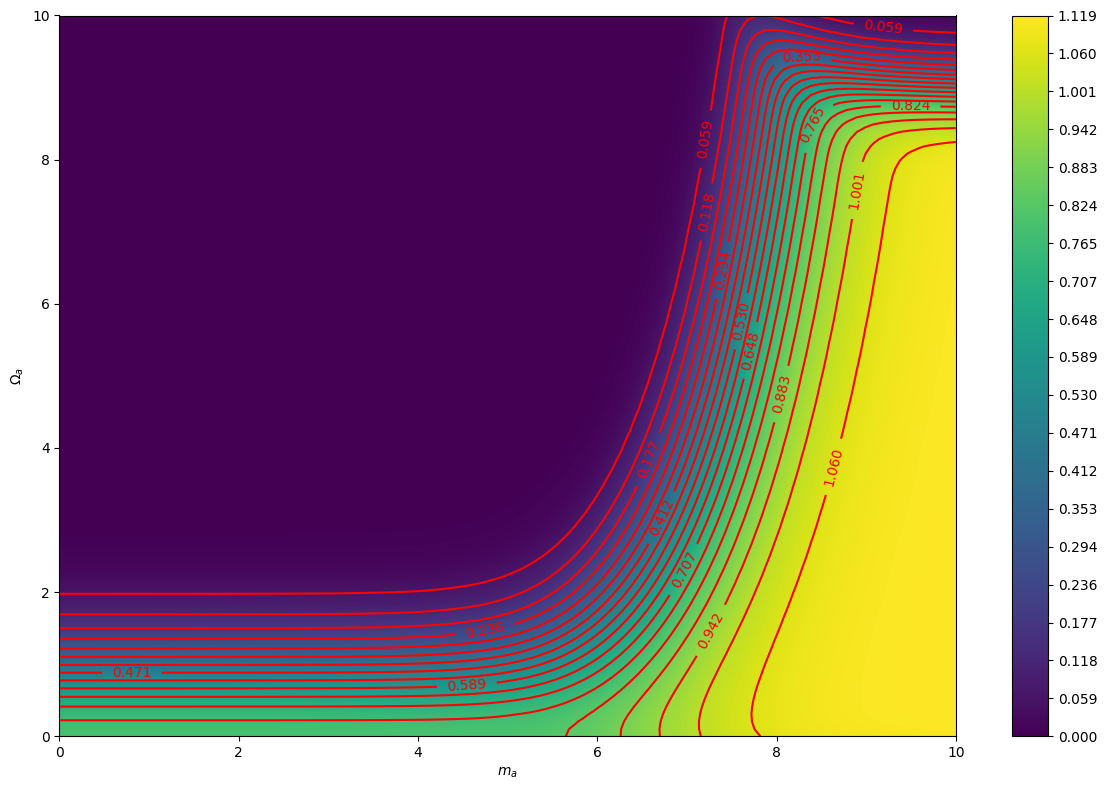

In [9]:
npoints = 500

# min and max for the contours
contour_min = np.min(integrated_likelihood)
contour_max = np.max(integrated_likelihood)

integrated_ma, integrated_omega_a = Z[0], X[0]  # these need to be formatted in the right way

# plot
plt.figure(figsize = (12, 8))
plt.contourf(integrated_ma, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20))#, update_ticks=True)

plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')

# CONTOURS
fig = plt.contour(integrated_ma, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, 20), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

# save
plt.savefig('integrated_3d_u_function_dm.png')#, fmt='png')
plt.show()